# Full multiclass dog breed classification

using TF 2.0 and TF Hub

## 1. Problem
Identify breed from image

## 2. Data
The data we're using is from Kaggle's dataset
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction proba for each dog breed of each test img

## 4. Features
* images of dogs (unstructured data) so use deep/transfer learning.
* There are 120 different labeled breeds
* There are +10,000 images in training set
* There are +10,000 images in test set


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/DogVision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Notebooks/DogVision/"

In [ ]:
# Import TF into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices else "not available")

TF version: 2.4.0
TF Hub version: 0.10.0
GPU available


## Get data into tensors (matrix)
all data has to be numerical

In [ ]:
# Checkout labels of data
import pandas as pd
# /content/drive/MyDrive/Colab Notebooks/DogVision/dog-breed-identification.zip
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DogVision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     bbe96d21f3aafe38ab3b3ce24a498d77  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
# How many images of each breed?
labels_csv["breed"].value_counts()
# labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));
# labels_csv["breed"].value_counts().median()
# google recommends at least 10 of each class

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [ ]:
# View an image
from IPython.display import Image
# Image("/content/drive/MyDrive/Colab Notebooks/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [ ]:
# Getting images and labels (list of paths)
# labels_csv.head()
# list comprehension
filenames = ["drive/MyDrive/Colab Notebooks/DogVision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
# Check if number of filenames matches image files

# length of the listdir
import os 
if len(os.listdir("drive/MyDrive/Colab Notebooks/DogVision/train/")) == len(filenames):
  print("Filenames match")
else:
  print("Filename numbers to not match")

Filenames match


In [ ]:
# Turn data labels into numbers
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
print(labels)
if len(labels) == len(filenames):
  print("Number of labels matches number of fn.")
else:
  print("Labels doesn't match filenames.")

['boston_bull' 'dingo' 'pekinese' ... 'airedale' 'miniature_pinscher'
 'chesapeake_bay_retriever']
Number of labels matches number of fn.


In [ ]:
# Find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn single label into array of booleans
# print(labels[0])
# labels[0] == unique_breeds

# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
# boolean_labels[:2]
len(boolean_labels)

10222

In [ ]:
# Turn boolean array into integers

# print(labels[0])
# print(np.where(unique_breeds == labels[0])) # index where label occurs
# print(boolean_labels[0]).argmax()) # index where label occurs in bool arr
# print(boolean_labels[0].astype(int)) # there will be a 1 where teh sample label occurs

## Creating validation set
Since Kaggle set doesn't contain a validation set we will create a validation set. (Split the training set)


In [ ]:
# Set up X & y vars
X = filenames
y = boolean_labels
len(filenames)

10222

In [ ]:
# Start of with 1000 images (start low then scale)

# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}

In [ ]:
# split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=.2,
                                                  random_state=42)
len(X_train), len(y_train), len( X_val),  len(y_val)

(800, 800, 200, 200)

## Preprocessing Images (turning data into Tensors)
write a function:
1. Take a filepath
2. use TensorFlow to read and save into var image
3. turn image into Tensors
4. Normalize 
5. resize image to be standard shape (224, 224)
6. return modified image

In [ ]:
# Convert Image to numpy arr
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape
# turn into tensor
# tf.constant(image)[:2]

(257, 350, 3)

In [ ]:
# define image size
IMG_SIZE = 224

# Create a function for preprocessing
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read file
  image = tf.io.read_file(image_path)
  # Turn jpg into numerical Tensor with RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (like OpenGL)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turn data into batches
Due to GPU memory limitations
Need data in form of Tensor tuples
`(image, label)`

In [ ]:
# TensorFlow likes batches (32 is default) (think sending VAO's)
# Create function to return Tensor tuple
def get_image_label(image_path, label):
  """
  returns Tensor tuple
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# demo above
# (process_image(X[42]), tf.constant(y[42]))

Make a function to turn all data (`X`, `y`) into batches

In [ ]:
# Define batch size
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches out of image (X) and label (y) pairs.
  Shuffles data if training data but not validation data.
  Accepts test data as input (no labels).
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    # Turn fp and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle data
    data = data.shuffle(buffer_size=len(X))
    # Create image label tuples (turns path into preprocessed image)
    data = data.map(get_image_label)
    # Batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches..


In [ ]:
# Check different attributes of batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
# Visulaize batches
import matplotlib.pyplot as plt
def show_25_images(images, labels):
  # setup figure
  plt.figure(figsize=(10,10))
  # loop 
  for i in range(25):
    # subplots (5 rows, 5col)
    ax = plt.subplot(5, 5, i+1)
    # display image
    plt.imshow(images[i])
    # add image label as ittle
    plt.title(unique_breeds[labels[i].argmax()])
    # turn grid lines off
    plt.axis("off")



In [ ]:
# turn train_data into iterator
train_images, train_labels = next(train_data.as_numpy_iterator())
# train_images, train_labels

In [ ]:
# Length of them:
len(train_images), len(train_labels)

(32, 32)

In [ ]:
# Visualize training data batch
show_25_images(train_images, train_labels)

In [ ]:
# Visualize valid set
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building a model
before build a model define:
* input shape (in form of Tensors)
* output shape (image labels, in form of Tensors)
* URL of model we want to use
Using transfer learning

from https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

Keras API is just a part of TensorFlow

In [ ]:
# Input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch height, width, color channels
# output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
# Setup model url from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Keras deep learning model
Create a function:
* takes input shape, output shape, model
* defines layers in Keras model in sequence
* compiles the model
* build the model 
* returns the model

In [ ]:
# builds Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # setup layers
  """
  read up on CNN, Dense, and softmax algorithm (activation functions)
  """
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 input layer
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output)
  ])
  # Compile (define how model is going to learn)
  """
  read on Adam optimization and Stochastic Gradient Descent and Loss functions
  """
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  # Build Model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
Callbacks are helper functions a model can use during training to save progress, check progress, or stop training if model isn't improving.

one for TensorBoard (tracks progress)
and onr for early stopping callback (prevents overfitting)

## TensorBoard Callback
1. Load notebook extention
2. Create TensorBoard callback (save and fit())
3. Visualize models with %tensorboard

### EarlyStopping Callback
early stopping helps stop our model from overfitting from stopping early

In [ ]:
# Load TensorBoard notebook extention
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Create TB callback
import datetime

def create_tensorboard_callback():
  # Create logdir for  storing logs
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/DogVision/logs",
                        # logs get tracked time whenever an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)



```
# This is formatted as code
```

## Training a model (on a subset of data)
First model is only going to train 1000 images (make sure everything is working

Epoch - 

the function:
* create model using create_model()
* setup TB callback using the
* call fit()
* return model

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Function that creats model
def train_model():
  """
  Train model and returns trained
  """
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x = train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model
# first epoch takes the longest

In [ ]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 373s 15s/step - loss: 5.0886 - accuracy: 0.0507 - val_loss: 3.3441 - val_accuracy: 0.2250
Epoch 2/100
25/25 [==============================] - 5s 183ms/step - loss: 1.9547 - accuracy: 0.6043 - val_loss: 2.0822 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 5s 181ms/step - loss: 0.6366 - accuracy: 0.9345 - val_loss: 1.5916 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 5s 183ms/step - loss: 0.2934 - accuracy: 0.9853 - val_loss: 1.4319 - val_accuracy: 0.6500
Epoch 5/100
25/25 [==============================] - 5s 183ms/step - loss: 0.1555 - accuracy: 0.9986 - val_loss: 1.3598 - val_accuracy: 0.6550
Epoch 6/100
25/25 [==============================] - 5s 181ms/step - loss: 0.1062 - accuracy: 0.9998 - val_loss: 1.3178 - val_accuracy: 0.6650
Epoch 7/100
25/25 [==============================

**Question**:
Model is overfitting because it performing on training set compared to valid set.
Note: overfitting means model is learning!

### Checking TB logs
TB magic function %tensorboard will access the logs dir we created earlier and visualize its contents

In [ ]:
%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/DogVision/logs

### Predictions

In [ ]:
# make predictions on validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
# Information
# print(predictions.shape)
# print(len(y_val))
# print(len(unique_breeds))
# print(len(predictions[0]))
# print(np.sum(predictions[0])) # sum of probabilities ~ 1 (softmax activation)


7/7 [==============================] - 1s 118ms/step


In [ ]:
# Inspect predictions see (237)
index = 0
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

Predicted label: irish_wolfhound


## Probabilities to language

create function

unbatch dataset

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

In [ ]:
def unbatchify(data):
  """
  Takes a batcheded dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

In [ ]:
val_images, val_labels = unbatchify(val_data)
# val_images[0], val_labels[0]
get_pred_label(val_labels[0])

'affenpinscher'

### Visualize predictions
* takes array of predictions probabilities, labels, and images, and integers
* convert proba to label
* plot label, proba, truth, and target

Top 10 predictions function
* take input of proba, truth, and integer
* find predictions
* find top 10:
  * pred proba index
  * pred proba vals
  * pred lab
* pplot top 10, coloring true green

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  # Get pred label
  pred_label = get_pred_label(pred_prob)
  # Plot img and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color based on correctness
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of pred and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
            color = color)


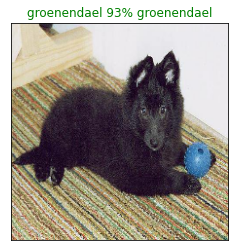

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest predictions along with labels for n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  # get pred label
  pred_label = get_pred_label(pred_prob)
  # find top 10 highest index
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1] # decending top 10 highest index by value 
  # find top 10 prediction values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color if true
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass



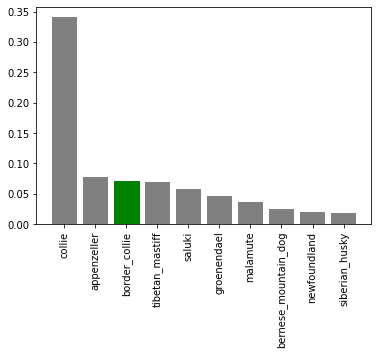

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

### Check a few predictions


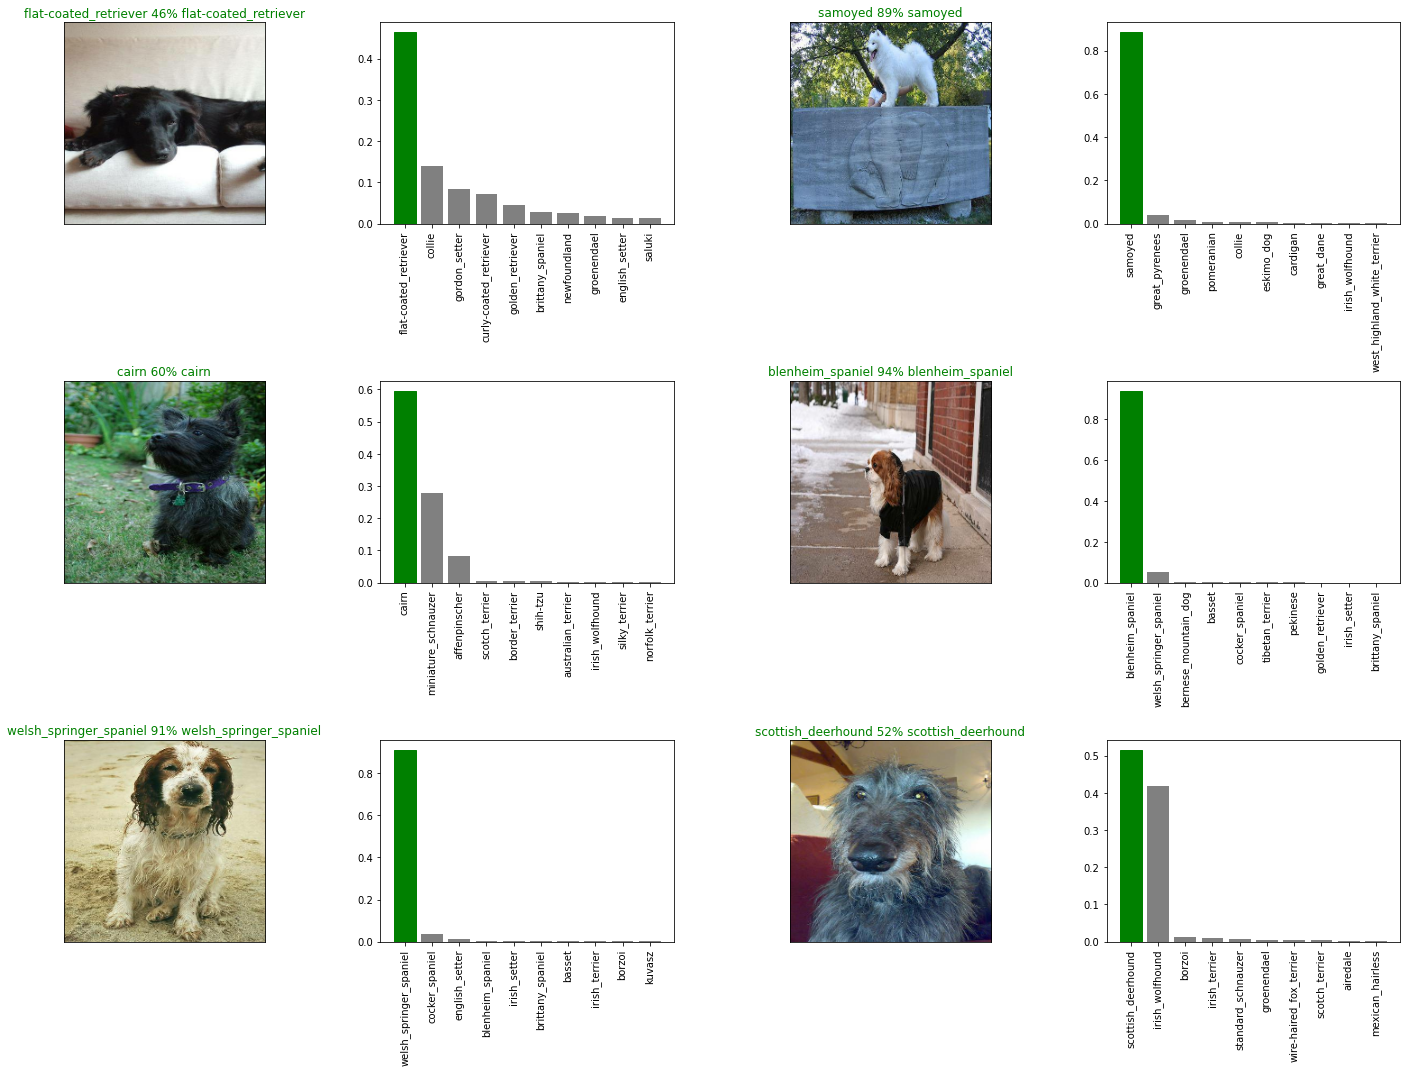

In [ ]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
               labels=val_labels,
               images=val_images,
               n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=i+i_multiplier)  
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** how would you create a confusion matrix with our models predictions and true labels?

# Saving and reloading a model

In [ ]:
import os
# Create function to save model
def save_model(model, suffix=None):
  """
  Saves given model in a models dir and appends a suffix (string)
  """
  # Create a model dir pathname with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/DogVision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading model: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save model trained on 1000 images
save_model(model, suffix="1000-imagesmobilenetv2-Adam")

Saving model to: drive/MyDrive/Colab Notebooks/DogVision/models/20201229-04221609215763-1000-imagesmobilenetv2-Adam.h5...


'drive/MyDrive/Colab Notebooks/DogVision/models/20201229-04221609215763-1000-imagesmobilenetv2-Adam.h5'

In [ ]:
# Load trained model
loaded_1000_image_model = load_model('/content/drive/MyDrive/Colab Notebooks/DogVision/models/20201229-04221609215763-1000-imagesmobilenetv2-Adam.h5')

Loading model: /content/drive/MyDrive/Colab Notebooks/DogVision/models/20201229-04221609215763-1000-imagesmobilenetv2-Adam.h5


In [ ]:
model.evaluate(val_data)
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 112ms/step - loss: 1.2032 - accuracy: 0.6900


[1.2032346725463867, 0.6899999976158142]

# Training on Full Data

In [ ]:
print(len(X))
print(len(y))

10222
10222


In [ ]:
# Create data batch with full data set
full_data = create_data_batches(X, y)
full_data

Creating training data batches...


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create Full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No valid set when training on full data, so can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

### Cell below will take a long time to run

In [ ]:
# Fit full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 3260s 10s/step - loss: 2.4068 - accuracy: 0.4800
Epoch 2/100
320/320 [==============================] - 39s 121ms/step - loss: 0.3913 - accuracy: 0.8899
Epoch 3/100
320/320 [==============================] - 39s 121ms/step - loss: 0.2273 - accuracy: 0.9434
Epoch 4/100
320/320 [==============================] - 39s 121ms/step - loss: 0.1472 - accuracy: 0.9680
Epoch 5/100
320/320 [==============================] - 40s 124ms/step - loss: 0.1007 - accuracy: 0.9815
Epoch 6/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0706 - accuracy: 0.9901
Epoch 7/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0583 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 39s 122ms/step - loss: 0.0447 - accuracy: 0.9960
Epoch 9/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0340 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 39s 121m

In [ ]:
# save Full model
save_model(model, suffix="all-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Colab Notebooks/DogVision/models/20201229-05561609221378-all-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Colab Notebooks/DogVision/models/20201229-05561609221378-all-images-mobilenetv2-Adam.h5'

In [ ]:
# load full model
loaded_full_model = load_model('/content/drive/MyDrive/Colab Notebooks/DogVision/models/20201229-05561609221378-all-images-mobilenetv2-Adam.h5')

Loading model: /content/drive/MyDrive/Colab Notebooks/DogVision/models/20201229-05561609221378-all-images-mobilenetv2-Adam.h5


## Making predictions of test set

Since trained on Tensor batches, need to make test data also Tensor batches

Use create_data_batces()

To make predictios on test data:
* Get test image filenames
* Convert fn into test data batches using `create_data_batches()` and setting the test_data param to True
* make pred arr by passing test batches into predict() called on our model


In [ ]:
# Load test image fn
test_path = "drive/MyDrive/Colab Notebooks/DogVision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Colab Notebooks/DogVision/test/f157256196b2c6e28a739d2947e956e5.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/eb8d19898e69b355679f98fe068cb06a.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/f4f77d0d3e23e06fe2c1941edf919eb3.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/f53c0a1ab2af3549a2ef5825d023b160.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/ebd77a2851ff497cbabda3639a82857c.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/e9f806911b69ca8fe705006ab7b49bdf.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/f58ce44146db339a0bba50bcecb02730.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/ece4530999e8c3ec85d2a86d33f07e37.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/f4a3d9cf1909fb5d894ff5d5121af9b0.jpg',
 'drive/MyDrive/Colab Notebooks/DogVision/test/f31ed6141b0976f85aaef9b69509c939.jpg']

In [ ]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)
test_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note** Calling predict() on full model will take a long time to run > 1hr

In [ ]:
# Make predictions on test data using model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 3868s 12s/step


In [ ]:
# Save predictions
np.savetxt("drive/MyDrive/Colab Notebooks/DogVision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
# Load predictions from csv
test_predictions = np.loadtxt("drive/MyDrive/Colab Notebooks/DogVision/preds_array.csv", delimiter=",")

OSError: ignored

### Kaggle Submission Format

* create pandas df with ID column and column for each dog breed
* add data to id col
* add pred proba to each dog breed col
* export df as csv

In [ ]:
# Create a df with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions df
test_ids = [os.path.splittext(path)[0] for path in os.listdir(test_path)]
# test_ids
preds_df["id"] = test_ids

In [ ]:
# add pred proba to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [ ]:
# Save predictions df to CSV for kaggle
preds_df.to_csv("drive/MyDrive/Colab Notebooks/DogVision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False))

# Make predictions on Custom Images

1. get filepaths of images
2. Turn into the same data using create_data_batches() and test_data=True
3. Pass custom image data batch to predict()
4. convert prediction output proba to prediction labels
5. Compare predicted labels to custom images

In [ ]:
# 1. 
custom_path = "drive/MyDrive/Colab Notebooks/DogVision/myimages/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
# custom_image_paths

In [ ]:
# 2. 
custom_data = create_data_batches(custom_image_paths, test_data=True)
# custom_data

In [ ]:
# 3. 
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

In [ ]:
# 4. 
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# 5. 
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


In [ ]:
# 5. 
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)